In [29]:
import streamlit as st

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2
import os
import numpy as np
import pandas as pd
import pathlib

# Example usage of the deprecated function
# y_true and y_pred should be defined appropriately
# loss = tf.losses.sparse_softmax_cross_entropy(labels=y_true, logits=y_pred)

# Recommended usage
# loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=y_true, logits=y_pred)

In [3]:
data_dir = r"C:\Users\91630\OneDrive\Documents\Rice_Image_Dataset" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/91630/OneDrive/Documents/Rice_Image_Dataset')

In [4]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

In [5]:
# Contains the images path
df_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
df_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

In [6]:
img = cv2.imread(str(df_images['arborio'][0])) # Converting it into numerical arrays
img.shape # Its currently 250 by 250 by 3

(250, 250, 3)

In [8]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])

In [9]:
# Standarizing
X = np.array(X)
X = X/255
y = np.array(y)

In [10]:
# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [11]:
mobile_net_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'  # MobileNetv2 link
mobile_net = hub.KerasLayer(mobile_net_url, input_shape=(224, 224, 3), trainable=False)  # Removing the last layer

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)


TensorFlow version: 2.16.2
TensorFlow Hub version: 0.16.1


In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
import os
import logging

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Set to 3 to filter out INFO and WARNING messages

# Suppress deprecation warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# MobileNetv2 link
mobile_net_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
mobile_net = hub.KerasLayer(mobile_net_url, input_shape=(224, 224, 3), trainable=False)  # Removing the last layer

num_label = 5  # number of labels

# Using the functional API
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Lambda(lambda input_tensor: mobile_net(input_tensor, training=False))(inputs)
outputs = layers.Dense(num_label)(x)
model = models.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,405 (25.02 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [15]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - acc: 0.6810 - loss: 0.9447 - val_acc: 0.9574 - val_loss: 0.2102
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - acc: 0.9713 - loss: 0.1550 - val_acc: 0.9574 - val_loss: 0.1432
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - acc: 0.9805 - loss: 0.0999 - val_acc: 0.9628 - val_loss: 0.1149
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.9800 - loss: 0.0860 - val_acc: 0.9681 - val_loss: 0.0965
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - acc: 0.9842 - loss: 0.0716 - val_acc: 0.9787 - val_loss: 0.0896
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - acc: 0.9882 - loss: 0.0549 - val_acc: 0.9787 - val_loss: 0.0807
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.9911 - loss: 0.0519 - val_acc: 0.9840 - val_loss: 0.0729
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.9954 - loss: 0.0379 - val_acc: 0.9787 - val_loss: 0.0709
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - acc: 0.9901 -

In [16]:
model.evaluate(X_test,y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - acc: 0.9960 - loss: 0.0467


[0.0462796576321125, 0.9928825497627258]

In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       122
           1       1.00      1.00      1.00       117
           2       1.00      1.00      1.00       104
           3       1.00      0.98      0.99       100
           4       0.98      0.99      0.99       119

    accuracy                           0.99       562
   macro avg       0.99      0.99      0.99       562
weighted avg       0.99      0.99      0.99       562



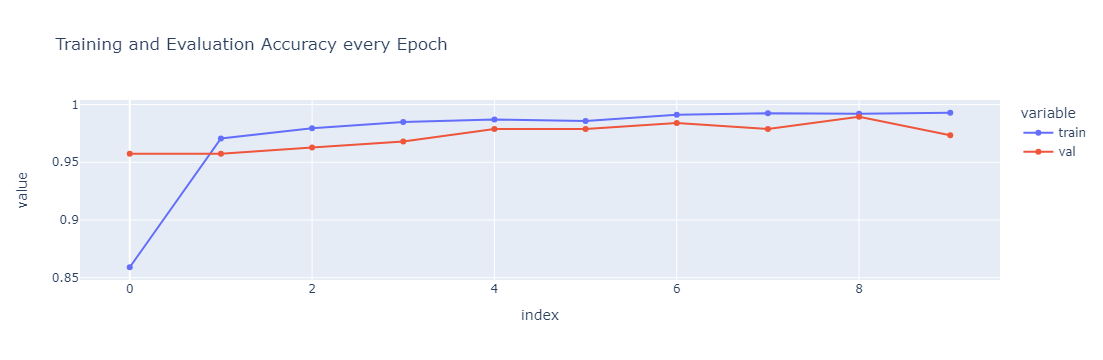

In [18]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas as pd

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()

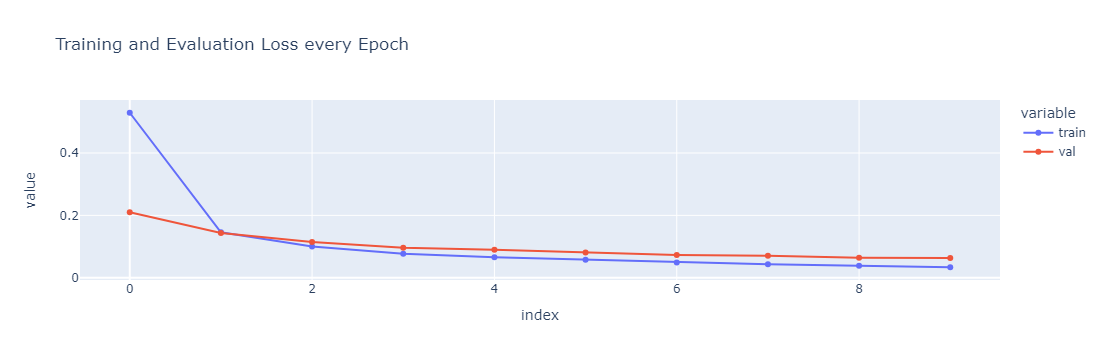

In [19]:
loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()

In [20]:
X_test[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [21]:
X_test.shape

(562, 224, 224, 3)

In [22]:
a1 = cv2.imread(r"C:\Users\91630\OneDrive\Documents\Rice_Image_Dataset\Jasmine\Jasmine (10).jpg")
a1 = cv2.resize(a1,(224,224))
a1 = np.array(a1)
a1 = a1/255
a1 = np.expand_dims(a1, 0)
pred = model.predict(a1)
pred = pred.argmax()
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step


3

In [23]:
for i, j in df_labels.items():
    if pred == j:
        print(i)

jasmine


In [24]:
a2 = cv2.imread(r"C:\Users\91630\OneDrive\Documents\Rice_Image_Dataset\Basmati\basmati (10).jpg")
a2 = cv2.resize(a2,(224,224))
a2 = np.array(a2)
a2 = a2/255
a2 = np.expand_dims(a2, 0)
a2.shape

(1, 224, 224, 3)

In [25]:
model.save("rice.h5")

In [31]:
!pip install streamlit nbconvert

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/53.0 kB ? eta -:--:--
   ----------------------- ---------------- 30.7/53.0 kB ? eta -:--:--
   ------------------------------ --------- 41.0/53.0 kB 326.8 kB/s eta 0:00:01
   ---------------------------------------- 53.0/53.0 kB 342.2 kB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.4.3 requires jedi<0.19.0,>=0.17.2, but you have jedi 0.19.1 which is incompatible.


In [32]:
!jupyter nbconvert --to script rice_classification final.ipynb

This application is used to convert notebook files (*.ipynb)

[NbConvertApp] WARNING | pattern 'rice_classification' matched no files
[NbConvertApp] WARNING | pattern 'final.ipynb' matched no files



        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue noteboo

In [33]:
import streamlit as st

# Add this line to show the title
st.title("My Jupyter Notebook in Streamlit")

# Add this line to display text
st.write("This is a Streamlit app running a Jupyter Notebook")

# Add the code from the notebook here
# For example:
def main():
    # Notebook code here
    st.write("Hello, Streamlit!")

if __name__ == "__main__":
    main()

2024-07-20 16:37:38.006 
  command:

    streamlit run C:\Users\91630\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
